In this notebook we will train a hybrid quantum convolutional neural network (QCNN) model to categorise the MNIST dataset.

This hybrid QCNN model consists of data preprocessing with a quantum circuit, then using a classical CNN to process the data and learn.

# Libraries

Our libraries will be the usual pennylane, along with tensorflow for the data and model-creating:

In [2]:
import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

# Data & Initial Hyperparameters

We initialise some hyperparameters like number of epochs & layers, and amount of train & test data; and then load the MNIST dataset from keras:

In [42]:
n_epochs = 60
n_layers = 1  # we have used different number of layers to train different models. feel free to change the number to see the effect

# train and test have low amount as to have faster computation. feel free to change or comment these to work with more amount of data
n_train = 50
n_test = 30

SAVE_PATH = os.path.expanduser("~/Downloads/QARS/Task3_data/")  # change save path to your needs
PREPROCESS = True

# setting seeds for reproducability
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
os.makedirs(SAVE_PATH, exist_ok=True)  # creating the save path

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()  # loading the train and test data

# restricting the data/lowering the data amount. comment these to use all MNIST dataset
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# normalising the data to (0, 1)
train_images = train_images / 255
test_images = test_images / 255

# changing to np array and adding new dimension to be able to feed into quantum and classsical models without error
train_images = np.array(train_images[..., np.newaxis], requires_grad=False)
test_images = np.array(test_images[..., np.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Quantum Ansatz

We implement our quantum circuit with angle embedding and using random layers (with constant seed 42) as ansatz. The number of layers has been define before, and random parameters were initialised for the random layer gates.

Our measurement is for all qubits since we want to have preprocessing for all different channels:

In [43]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    RandomLayers(rand_params, wires=list(range(4)))
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Here is what our current circuit looks like:

In [44]:
print(qml.draw(circuit, expansion_strategy="device")([0,0,0,0]))

0: ──RY(0.00)──────────────────────────────────┤  <Z>
1: ──RY(0.00)──RY(3.72)─╭●─────────────────────┤  <Z>
2: ──RY(0.00)──RX(5.30)─│───RZ(5.39)──RX(5.32)─┤  <Z>
3: ──RY(0.00)───────────╰X─────────────────────┤  <Z>


We have also created 2 other circuits with different layers to compare performance.
The comparison will be stated later on in the evaluation section:

In [36]:
print(qml.draw(circuit, expansion_strategy="device")([0,0,0,0]))  # circuit with 2 layers

0: ──RY(0.00)──────────────╭X─────────────────────────────────────────┤  <Z>
1: ──RY(0.00)──RY(3.72)─╭●─╰●─────────RY(0.36)────────────────────────┤  <Z>
2: ──RY(0.00)──RX(5.30)─│───RZ(5.39)──RX(5.32)──RY(2.42)─╭X──RY(1.87)─┤  <Z>
3: ──RY(0.00)───────────╰X──RY(3.92)─────────────────────╰●───────────┤  <Z>


In [11]:
print(qml.draw(circuit, expansion_strategy="device")([0,0,0,0]))  # circuit with 3 layers

0: ──RY(0.00)──────────────╭X─────────────────────────────────────────╭●──────────────────┤  <Z>
1: ──RY(0.00)──RY(5.82)─╭●─╰●─────────RY(6.15)──RX(2.90)──────────────│──────────RZ(0.74)─┤  <Z>
2: ──RY(0.00)──RX(0.45)─│───RZ(0.55)──RX(0.13)──RY(4.89)─╭X──RY(5.47)─╰X──────────────────┤  <Z>
3: ──RY(0.00)───────────╰X──RY(5.23)─────────────────────╰●──RZ(5.02)──RY(4.90)───────────┤  <Z>


# Quantum Convolution Preprocessing

We now use our circuit to preprocess the data so we can then feed it into a CNN:

In [12]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):  # convolution process. notice we used the circuit above to calculate the data
            q_results = circuit([
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ])
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

And now we start the preprocessing sequence:

In [45]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


Here are some samples and the channels the quantum circuit has preprocessed them. You can see the circuit did a good job at acquiring the patterns in the data, close to what a classical convolution algorithm works:

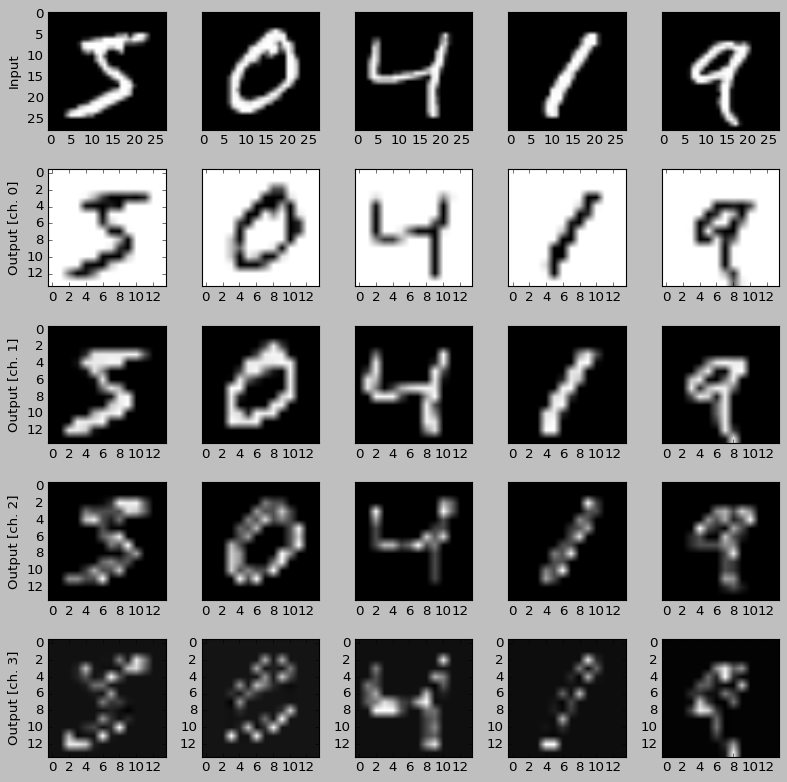

In [46]:
n_samples = 5
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# QCNN and CNN models

Here we create 2 models, a QCNN and a classical CNN so then we can compare the performance.

Both models' CNN part contains 3 layers of Conv2D, 2 Pooling layers, a Flatten, and 2 Dense layers (last dense layer is to categorise to 10 classes of numbers from 0-9).

The same activation functions, optimiser, loss, and metrics are applied:

In [15]:
def create_classical_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
def create_quantum_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(14, 14, 4)),  # note how the input shape is different in quantum compared to classical
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Training

And now we train our models:

In [47]:
print("Training quantum model...")
q_model = create_quantum_model()
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),  # validation to see how our model is doing in the test data
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Training quantum model...
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 2s - 152ms/step - accuracy: 0.0800 - loss: 2.3580 - val_accuracy: 0.0333 - val_loss: 2.2826
Epoch 2/60
13/13 - 0s - 9ms/step - accuracy: 0.1600 - loss: 2.2387 - val_accuracy: 0.0333 - val_loss: 2.2596
Epoch 3/60
13/13 - 0s - 14ms/step - accuracy: 0.2000 - loss: 2.1028 - val_accuracy: 0.2000 - val_loss: 2.1360
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 0.5200 - loss: 1.8628 - val_accuracy: 0.5000 - val_loss: 1.8990
Epoch 5/60
13/13 - 0s - 9ms/step - accuracy: 0.7000 - loss: 1.4835 - val_accuracy: 0.6333 - val_loss: 1.4896
Epoch 6/60
13/13 - 0s - 10ms/step - accuracy: 0.8200 - loss: 1.0164 - val_accuracy: 0.8667 - val_loss: 1.0515
Epoch 7/60
13/13 - 0s - 11ms/step - accuracy: 0.8400 - loss: 0.6215 - val_accuracy: 0.7000 - val_loss: 0.8377
Epoch 8/60
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.2804 - val_accuracy: 0.7333 - val_loss: 0.7507
Epoch 9/60
13/13 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.1357 - val_accuracy: 0.8333 - val_loss: 0.4842
Epoch 10/60
13/13 - 0s

In [48]:
print("Training classical model...")
c_model = create_classical_model()
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Training classical model...
Epoch 1/60
13/13 - 2s - 178ms/step - accuracy: 0.0800 - loss: 2.3301 - val_accuracy: 0.1667 - val_loss: 2.2783
Epoch 2/60
13/13 - 0s - 26ms/step - accuracy: 0.3000 - loss: 2.1731 - val_accuracy: 0.2667 - val_loss: 2.1389
Epoch 3/60
13/13 - 0s - 26ms/step - accuracy: 0.4400 - loss: 1.8087 - val_accuracy: 0.5000 - val_loss: 1.7052
Epoch 4/60
13/13 - 1s - 49ms/step - accuracy: 0.6800 - loss: 1.0924 - val_accuracy: 0.7000 - val_loss: 1.1050
Epoch 5/60
13/13 - 1s - 40ms/step - accuracy: 0.8800 - loss: 0.4826 - val_accuracy: 0.6333 - val_loss: 1.1984
Epoch 6/60
13/13 - 0s - 21ms/step - accuracy: 0.9800 - loss: 0.1488 - val_accuracy: 0.6333 - val_loss: 1.3702
Epoch 7/60
13/13 - 0s - 22ms/step - accuracy: 0.9600 - loss: 0.0763 - val_accuracy: 0.7333 - val_loss: 1.1297
Epoch 8/60
13/13 - 0s - 25ms/step - accuracy: 0.9800 - loss: 0.0832 - val_accuracy: 0.7000 - val_loss: 1.3088
Epoch 9/60
13/13 - 0s - 18ms/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 0.7000 

# Evaluation

As we can already see, the quantum model does way better because of the specific gates and parameters in the quantum circuit.

We now plot the performance of quantum vs classical:

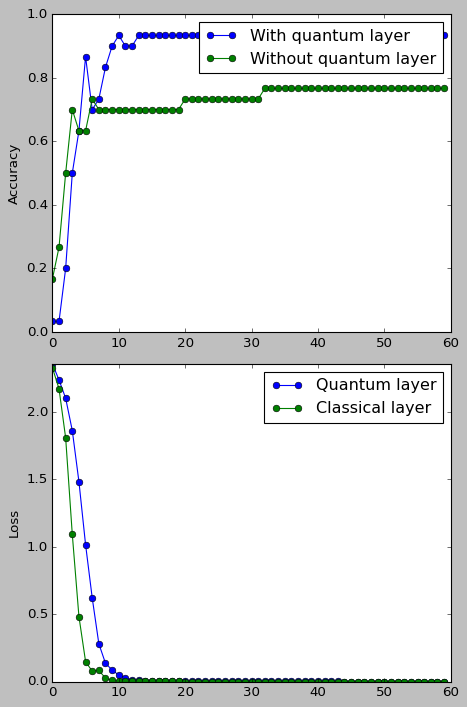

In [49]:
plt.style.use("classic")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
if 'q_history' in globals() and 'c_history' in globals():
    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()

    ax2.plot(q_history.history["loss"], "-ob", label="Quantum layer")
    ax2.plot(c_history.history["loss"], "-og", label="Classical layer")
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, max(max(q_history.history["loss"]), max(c_history.history["loss"]))])
    ax2.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Error: One or both model histories are not defined.")

We can see the quantum is way better with more than 90% accuracy!

Please note that every time you run the circuit cell, the parameters may change (due to randomness) and therefore may create very bad or very good models.

The other models (with 2 layer and 3 layer circuits) did a poor job at categorising.
- 2 layers: 67% accuracy
- 3 layers: 73% accuracy

This shows that extra care is needed while designing ansatzes with more layers, and may need introduction of other gates.

# Summary & suggestions to make it better

QCNN models may work better in some cases, but since this is a new field of technology, classical models are more trustworthy.

This does not mean we should keep using classical models. Quantum models have the potential of using various quantum mechanics (entanglement, superposition, teleportation, etc.) to calculate and learn more efficiantly, or faster.

To make the quantum models in this notebook better, we can apply optimisation techniques on the parameters given to the layer of gates in the ansatz; or change the tasks of quantum and classical parts (e.g. classical preprocessing and quantum training instead of quantum preprocessing and classical training).

There are also methods regarding the dataset and hyperparemeters; changing them also impacts the results.